In [2]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00


In [3]:
!python -m spacy download en_core_web_lg

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-23 17:11:12.703208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 17:11:15.693071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-23 17:11:15.693285: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

In [4]:
import os
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
data = pd.read_csv('/gdrive/My Drive/DecisionTree/Reddit.nba/NBA_1000comments.csv')
data

,Comment ID,Author,Timestamp,Comment is a reply to,Comment Thread ID,Thread Title,Comment Body,Comment Permalink
0,j8pbjbz,Wontonsoupz,2023-02-15 23:51:33,t3_113c97f,113c97f,Why was Kobe an all star in 97/98?,"Because he’s Kobe, you could argue he didn’t d...",/r/nba/comments/113c97f/why_was_kobe_an_all_st...
1,j8pb0u3,Thorlolita,2023-02-15 23:47:49,t3_113c97f,113c97f,Why was Kobe an all star in 97/98?,Because he’s Kobe and is a laker,/r/nba/comments/113c97f/why_was_kobe_an_all_st...
2,j8pbf3t,transizzle,2023-02-15 23:50:41,t3_113c97f,113c97f,Why was Kobe an all star in 97/98?,[Dunks.](https://www.youtube.com/watch?v=pKTLx...,/r/nba/comments/113c97f/why_was_kobe_an_all_st...
3,j8pbtt2,bl123123bl,2023-02-15 23:53:39,t3_113c97f,113c97f,Why was Kobe an all star in 97/98?,Young exciting upcoming star who won a dunk co...,/r/nba/comments/113c97f/why_was_kobe_an_all_st...
4,j8pbv4v,longschlng22,2023-02-15 23:53:55,t3_113c97f,113c97f,Why was Kobe an all star in 97/98?,Back when all star starters were 100% fan vote...,/r/nba/comments/113c97f/why_was_kobe_an_all_st...
...,...,...,...,...,...,...,...,...
1018,j8ovnir,Pasta_Ssempa_,2023-02-15 22:00:17,t1_j8ovf57,113977x,foul up 3 potential rule,That’s not what only needing a stop means. The...,/r/nba/comments/113977x/foul_up_3_potential_ru...
1019,j8p1w8i,toanisintheballz,2023-02-15 22:42:40,t1_j8p1sch,113977x,foul up 3 potential rule,"Sounds cool, I'll check it out !",/r/nba/comments/113977x/foul_up_3_potential_ru...
1020,j8paxq8,unearthlysquire,2023-02-15 23:47:09,t1_j8p8l5n,113977x,foul up 3 potential rule,Bro had a dumbass idea and instead of defendin...,/r/nba/comments/113977x/foul_up_3_potential_ru...
1021,j8own79,Usual_Adhesiveness92,2023-02-15 22:06:53,t1_j8ovnir,113977x,foul up 3 potential rule,Steal the ball and get possession that way.,/r/nba/comments/113977x/foul_up_3_potential_ru...


In [7]:
import spacy #load spacy
nlp = spacy.load("en_core_web_lg")
def normalize(review, lowercase, remove_stopwords):
    if lowercase:
        review = review.lower()
    doc = nlp(review)
    lemmatized = list()
    for token in doc:
        if not remove_stopwords or (remove_stopwords and not token.is_stop):
            lemmatized.append(token.lemma_)
    return " ".join(lemmatized)
data['processed'] = data['Comment Body'].apply(normalize, lowercase=True, remove_stopwords=True)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [21]:
tokenizer = RegexpTokenizer(r'\w+')
cv = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df= 0.95, min_df= 0.0001)

# Fit and Transform the documents
train_data = cv.fit_transform(data['processed']) 
train_data

<1023x2937 sparse matrix of type '<class 'numpy.int64'>'
	with 9931 stored elements in Compressed Sparse Row format>

In [9]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb
import numpy as np

In [22]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

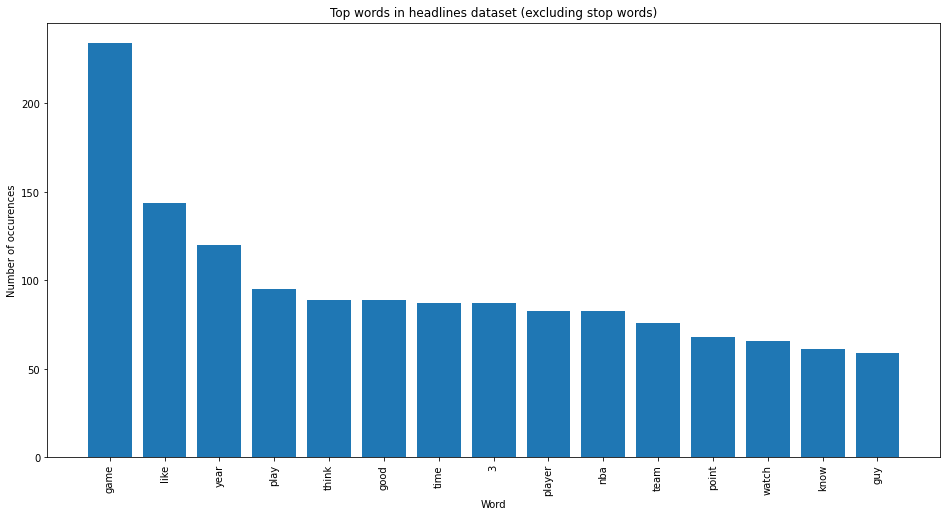

In [23]:
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=cv, 
                                     text_data=data['processed'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [34]:

num_components=15
model=LatentDirichletAllocation(n_components=num_components, random_state= 0, verbose =1, evaluate_every= 2, max_iter= 20)
lda_matrix = model.fit_transform(train_data)
lda_components=model.components_

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20, perplexity: 3135.5850
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20, perplexity: 3033.4848
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20, perplexity: 2984.4264
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20, perplexity: 2949.9284
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20, perplexity: 2924.6855
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20, perplexity: 2914.3390
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20, perplexity: 2909.6691
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20, perplexity: 2901.8965
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20, perplexity: 2889.0880
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20, perplexity: 2884.3329


In [36]:
terms = cv.get_feature_names()

for index, component in enumerate(lda_components):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['robinson', 'year', '3', 'like', 'time', 'spur', 'sign', 'try', 'team', 'dame']
Topic 1:  ['game', '6', 'final', '7', 'celebration', 'time', 'need', 'stop', 'watch', 'vs']
Topic 2:  ['play', '3', 'good', 'game', 'point', 'like', 'year', 'player', 'bird', 'think']
Topic 3:  ['year', 'game', 'star', 'lol', 'say', 'player', 'play', 'dunk', 'come', 'like']
Topic 4:  ['think', 'like', 'game', 'year', 'trade', 'people', 'watch', 'know', '3pt', 'shooter']
Topic 5:  ['game', 'like', 'team', 'time', 'people', 'kobe', 'player', 'season', '3', 'draft']
Topic 6:  ['comments', 'nba', 'look', 'lebron', 'https', 'star', 'com', 'game', 'like', 'highlight']
Topic 7:  ['like', 'mad', 'dog', 'jj', 'time', 'good', 'vin', 'guy', 'think', 'game']
Topic 8:  ['great', 'point', 'game', '3', 'wilt', '100', 'basketball', 'nba', 'time', 'love']
Topic 9:  ['player', 'nba', 'dunk', 'want', 'contest', 'like', 'imagine', 'street', 'watch', 'way']
Topic 10:  ['malone', 'post', 'karl', 'team', 'perform', 'nb

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [37]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, train_data, cv, mds='tsne')

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [38]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      112.381653  150.428421       1        1  14.373395
7     -265.765076 -186.693298       2        1   9.132725
3      -25.376986  329.944366       3        1   8.709436
1      340.276764  198.592041       4        1   7.577954
5      -93.208519  -75.316956       5        1   7.230051
4       85.089966  -93.397285       6        1   6.911289
11     188.575409  350.408325       7        1   6.726323
12     309.048218 -190.711777       8        1   6.608160
6      232.699005   10.375868       9        1   5.867584
10     439.166809   -6.989732      10        1   5.733764
0      -67.949135 -289.887207      11        1   5.536998
13     137.004517 -303.175751      12        1   4.147419
9     -224.670135  248.202469      13        1   4.048500
14    -279.578400   38.073643      14        1   4.019428
8      -62.673553  106.943413      15        1   3.376974, topic_info=         Term        Freq       Total Category  logprob  loglift
1636   malone   37.000000   37.000000  Default  30.0000  30.0000
1161     game  187.000000  187.000000  Default  29.0000  29.0000
2013     post   36.000000   36.000000  Default  28.0000  28.0000
132         6   32.000000   32.000000  Default  27.0000  27.0000
1075    final   34.000000   34.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1364  imagine    1.397005   13.859858  Topic15  -5.5754   1.0935
1849      old    1.397005   30.498801  Topic15  -5.5754   0.3048
991      espn    1.397005    9.539777  Topic15  -5.5754   1.4671
2105     real    1.397005   14.214319  Topic15  -5.5754   1.0683
300     argue    1.397005   11.789867  Topic15  -5.5754   1.2553

[1057 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.138282         0
0         3  0.276565         0
0         9  0.553129         0
2         5  0.516246       000
2        14  0.258123       000
...     ...       ...       ...
2924      8  0.242786     young
2924     13  0.080929     young
2924     15  0.080929     young
2928     13  0.670808  yt_bllen
2931      8  0.860244      zaza

[2397 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 4, 2, 6, 5, 12, 13, 7, 11, 1, 14, 10, 15, 9])

In [29]:
model.score(train_data)

-86917.98711203827

In [35]:
model.perplexity(train_data)

2884.332894300122